# BornhutterFerguson vs Chainladder

In [1]:
import chainladder as cl

This example demonstrates the relationship between the Chainladder and
BornhuetterFerguson methods by way of the Benktander model. Each is a
special case of the Benktander model where ``n_iters = 1`` for BornhuetterFerguson
and as ``n_iters`` approaches infinity yields the chainladder.  As ``n_iters``
increases the apriori selection becomes less relevant regardless of initial
choice.

In [2]:
# Load Data
clrd = cl.load_sample('clrd').groupby('LOB').sum()
X = clrd.loc['medmal', 'CumPaidLoss']
sample_weight = clrd.loc['medmal', 'EarnedPremDIR'].latest_diagonal

# Specify Model
grid = cl.GridSearch(
    estimator=cl.Pipeline(steps=[
        ('dev', cl.Development()),
        ('tail', cl.TailCurve()),
        ('model', cl.Benktander())]), 
    param_grid = dict(
        model__n_iters=list(range(1, 100, 2)),
        model__apriori=[0.50, 0.75, 1.00]), 
    scoring={'IBNR': lambda x: x.named_steps.model.ibnr_.sum()},
    n_jobs=-1)

Because chainladder estimators are scikit-learn compatible, we can display them as expandable/collabsible diagrams.

In [3]:
from sklearn import set_config
set_config(display='diagram')
grid

GridSearch(estimator=Pipeline(steps=[('dev', Development()),
                                     ('tail', TailCurve()),
                                     ('model', Benktander())]),
           n_jobs=-1,
           param_grid={'model__apriori': [0.5, 0.75, 1.0],
                       'model__n_iters': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39,
                                          41, 43, 45, 47, 49, 51, 53, 55, 57,
                                          59, ...]},
           scoring={'IBNR': <function <lambda> at 0x000002666723AF20>})

Fitting this model will loop through all `param_grid` options we specified and retain the aggregate IBNR of the model we declared in our `scoring` function.

In [4]:
# Fit Model
grid.fit(X, sample_weight=sample_weight)

# Analyze results
output = grid.results_.pivot(
    index='model__n_iters', 
    columns='model__apriori', 
    values='IBNR') 
output.head()

model__apriori,0.50,0.75,1.00
model__n_iters,,,
1,8.326572e+05,1.248986e+06,1.665314e+06
3,1.075446e+06,1.289296e+06,1.503147e+06
5,1.150192e+06,1.308018e+06,1.465843e+06
7,1.189016e+06,1.318141e+06,1.447267e+06
9,1.214161e+06,1.324979e+06,1.435798e+06


Let's plot the results of our output DataFrame.

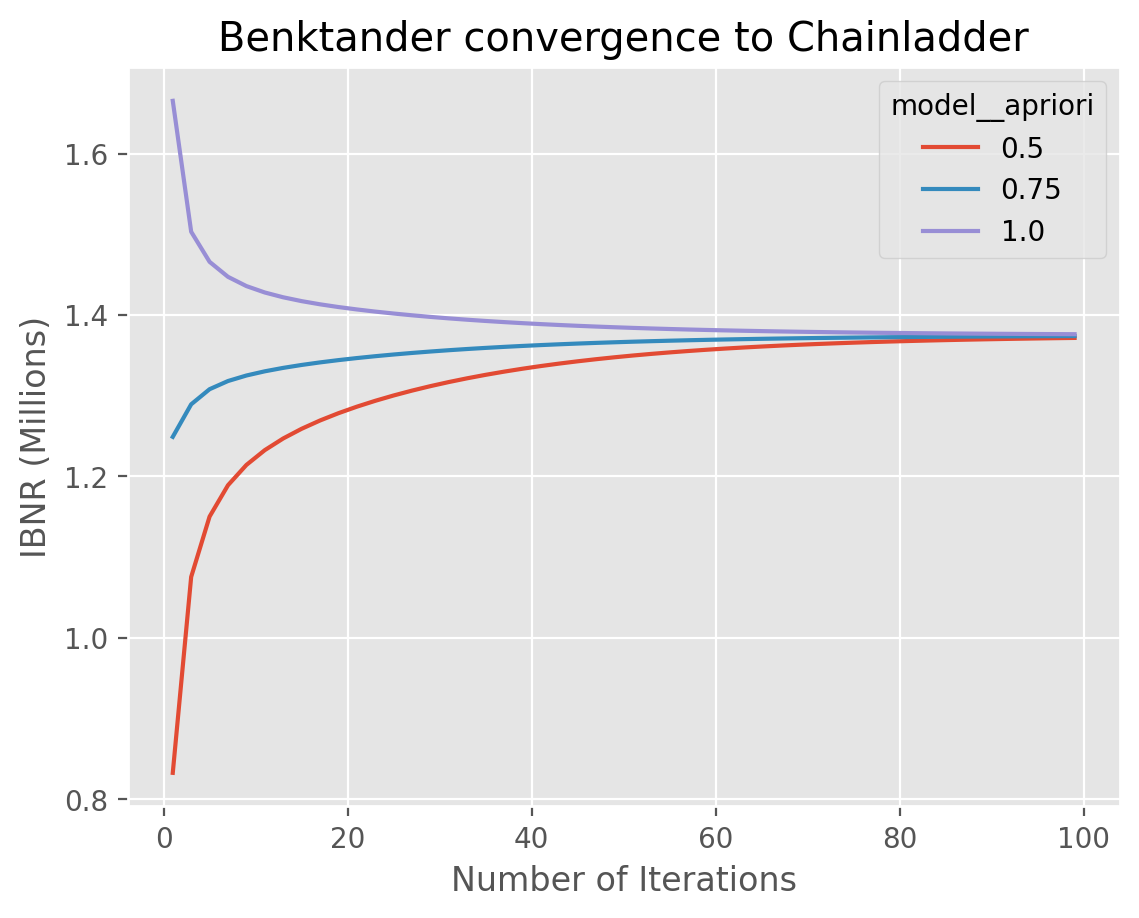

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

ax = (output / 1e6).plot(
    ylabel='IBNR (Millions)',
    xlabel='Number of Iterations',
    title='Benktander convergence to Chainladder');